<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_7_Aquifer_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

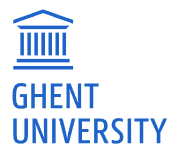<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 7 - Aquifer tests**

This notebook discusses the interpretation of two aquifer tests performed in the field. The first is a pumping test in a leaky aquifer, and the second is a slug test conducted in a partially penetrating well. The explanation provided with each example is relatively concise. To gain a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed models, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)

Importing module `inspect` will allow us to print the source code of the functions implemented in the `maxsypy` package.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy

# copy data files to current working directory
data_folder = './data'
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)
shutil.copytree("./maxsypy/seminaries/UM6P_jan_2025/data", data_folder)

# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 209 (delta 62), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (209/209), 7.19 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (96/96), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023).

## 1. Pumping test in a leaky aquifer

This section shows how to interpret a pumping test performed in a leaky aquifer. Two methods are applied to fit the pumping test data and derive the optimal values for the hydraulic parameters:
1. the [Levenberg-Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm);
2. the [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method).

### Pumping test data

Consider the pumping test data stored in file `'./data/pumping_test_data.txt'`:

In [3]:
!head ./data/pumping_test_data.txt

Observation well at 197 m from pumping well
Pumping well has discharge equal to 69.1 m³/h
Reference: Jiang Hui, Zeng Buo, Pan Hongyu, 2009. Groundwater Dynamics. Beijing, Geological Publishing House.

time (min)	drawdown (m)
1	0.05
4	0.054
7	0.12
10	0.175
15	0.26


Using Pandas to read the text-file as a `DataFrame`:

In [4]:
df = pd.read_csv('./data/pumping_test_data.txt',
                 sep='\t', skiprows=4)  # use tab as separator and skip first 4 rows
df.head()

,time (min),drawdown (m)
0,1,0.050
1,4,0.054
2,7,0.120
3,10,0.175
4,15,0.260


Plotting the data:

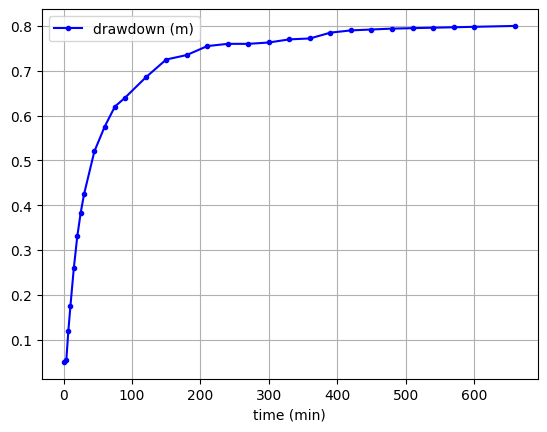

In [5]:
df.plot(x='time (min)', y='drawdown (m)',
        style='b.-', grid=True);

These data were observed during a pumping test conducted in a leaky aquifer consisting of gravel (Jiang Hui et al., 2009). The leakage came from an upper unconfined aquifer, which was separated from the extracted aquifer by an aquitard of silty sand. The fully penetrating pumping well extracted water at a constant rate equal to 69.1 m³/h. The observed drawdowns were measured in an observation well at a distance of 197 m from the pumping well:

In [6]:
Q = 69.1 * 24  # pumping rate in m³/d
r_obs = 197    # observation well distance in m

t_obs = df['time (min)'].values / 60 / 24  # observation times in days
s_obs = df['drawdown (m)'].values          # observed drawdowns in m

### Hantush-Jacob

Assuming the separating aquitard is incompressible and drawdown in the unconfined aquifer is negligibly small, the Hantush-Jacob (1955) model can be applied to simulate the pumping test. This model is used indeed to simulate transient one-dimensional axisymmetric flow to a pumping well in a leaky aquifer, as illustrated in the figure below:

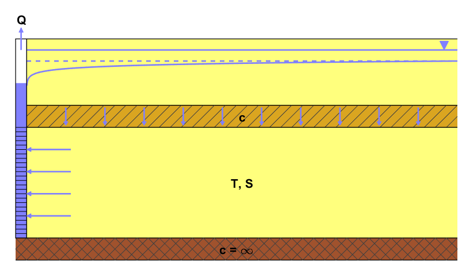

The Hantush-Jacob (1955) model can be simulated using function `hantush_jacob`, which implements two solution methods:

1. the numerical inversion of the Laplace solution using the Stehfest (1970) algorihtm;
2. a fast numerical approximation of the Hantush well function $W$  by Veling & Maas (2010).

In [7]:
from maxsypy.special import hantush_jacob

print(inspect.getdoc(hantush_jacob))

Simulate transient flow to a pumping well in a leaky aquifer.
The well has an infinitesimal radius and extracts water at a constant pumping rate.

The solution is obtained from numerical inversion of the exact analytical solution in Laplace space.
There is also the option to apply a fast approximation of the Hantush Well function W.
See input parameter `ns`.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
t : array_like
  One-dimensional array with the simulation times [T].
T : float
  Aquifer transmissivity [L²/T].
S : float
  Aquifer storativity [-].
Q : float
  Pumping rate [L³/T] of the well.
c_top : float
      Vertical resistance [T] of the aquitard overlying the aquifer.
h_top : float, default: 0.0
      Constant head [L] of the upper boundary condition, which is also the initial head in the aquifer.
ns : int, default: 12
   Stehfest number - must be a positive, even integer.
   If `ns` is `None`, then a fast approximation of the Hant

The hydraulic parameters are adopted from a rejected paper in which a random weight particle swarm optimization algorithm (RandWPSO) was applied to interpret the pumping test data:

In [8]:
T_ai = 403.9988961794492     # aquifer transmissivity (m²/d)
S_ai = 1.397843694485632E-4  # aquifer storativity (-)
c_ai = 1 / 1.334002E-3       # aquifer resistance (d)
c_ai

749.6240635321386

Simulating the Hantush-Jacob model using the parameters obtained from this AI method:

In [9]:
s_ai = hantush_jacob(r=r_obs, t=t_obs, Q=Q, T=T_ai, S=S_ai, c_top=c_ai)

Adding the simulated drawdown curve to the time-drawdown plot:

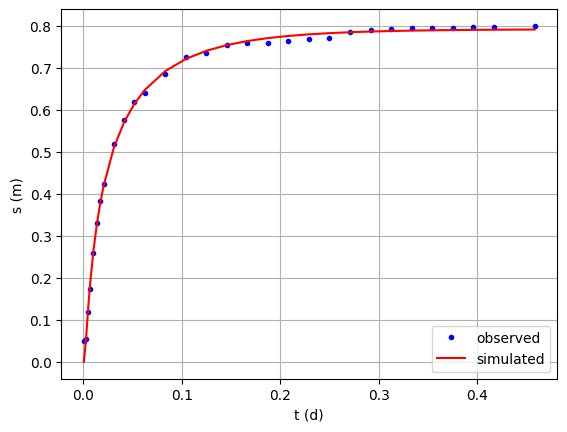

In [10]:
import matplotlib.pyplot as plt

plt.plot(t_obs, s_obs, 'b.', label='observed');
plt.plot(t_obs, s_ai[0], 'r-', label='simulated');
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.legend();

Indeed, there is a good correspondence between the observed and simulated drawdowns. However, the rejected paper states that the total computation time to derive the three hydraulic parameters was 4.5 minutes... So, this is not a computationally efficient method!

### Levenberg-Marquardt

This section shows how to use the traditional [Levenberg-Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) to interpret the pumping test data in a fraction of a second!

Just like in the rejected paper, the first observation is removed as it is not reliable:

In [11]:
t_obs, s_obs = t_obs[1:], s_obs[1:]  # removing the first observation

A function `residuals` is defined, where residual $\eta_i$ of observation $i$ is defined as:

> $\eta_i = \log_{10}{s_{obs, i}} - \log_{10}{s_{i}}$

with $s_{obs}$ the observed drawdown and $s$ the simulated drawdown.

Note the data are normalized by taking the logarithm of the drawdowns.

In [12]:
def residuals(logP):
    '''
    logP: array_like
        Logarithm of the optimized hydraulic parameters
        logP = [log10(T), log10(S), log10(c)]
    returns: ndarray
           Residuals of the observations
    '''
    T, S, c = tuple(10**logP)
    s = hantush_jacob(r=r_obs, t=t_obs, Q=Q, T=T, S=S, c_top=c)
    return np.log10(s_obs) - np.log10(s.flatten())

Using these residuals, the mean squared error (MSE) is calculated as:

> $MSE = \dfrac{1}{n}\sum_i{\eta_i^2}$

with $n$ the number of observations.

Calculating the MSE for the RandWPSO optimization:

In [13]:
MSE = lambda logP: np.mean(np.square(residuals(logP)))

print(f'MSE RandWPSO = {MSE(np.log10([T_ai, S_ai, c_ai]))}')

MSE RandWPSO = 6.556205477882494e-05


The Levenberg-Marquardt algorithm is available with SciPy function `least_squares`. Module `time` is used to time the computation.

In [14]:
from time import time
from scipy.optimize import least_squares

x0 = np.array([1, -5, 2])  # starting values for logP
start = time()
result = least_squares(fun=residuals, x0=x0, method='lm',
                       ftol=1e-12, xtol=1e-12, gtol=1e-12)
print(f"elapsed time: {time() - start} sec")

elapsed time: 0.10034871101379395 sec


Less than a tenth of a second is needed to perform the optimization! Let's check the result:

In [15]:
result

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.445e-02 -1.088e-02 ...  2.727e-03  3.484e-03]
           x: [ 2.622e+00 -3.857e+00  2.905e+00]
        cost: 0.000717604095003845
         jac: [[-8.608e-01  1.843e+00 -1.729e-02]
               [-2.910e-01  1.264e+00 -2.692e-02]
               ...
               [ 6.420e-01  9.516e-03 -3.485e-01]
               [ 6.422e-01  6.539e-03 -3.512e-01]]
        grad: [ 3.439e-05 -3.880e-05  9.276e-06]
  optimality: 3.880061054759602e-05
 active_mask: [0 0 0]
        nfev: 75
        njev: None

Printing the optimal values for the hydraulic parameters:

In [16]:
T_lm, S_lm, c_lm = tuple(10**result.x)
print(f"r/B = {r_obs/np.sqrt(T_lm*c_lm)}")
print(f"T = {T_lm}")
print(f"S = {S_lm}")
print(f"c = {c_lm}")
print(f"K/M = {1/c_lm}")

r/B = 0.33966118442493454
T = 418.38884431293474
S = 0.0001391052948927095
c = 804.0082714958618
K/M = 0.0012437682987259504


These values are very close to the optimal values obtained from the AI method, and actually, they may be considered more accurate as the MSE is smaller:

In [17]:
print(f'MSE Levenberg-Marquardt = {MSE(np.log10([T_lm, S_lm, c_lm]))}')

MSE Levenberg-Marquardt = 4.9489937586472084e-05


Simulating the Hantush-Jacob model using the optimal parameters obtained from the Levenberg-Marquardt regression:

In [18]:
s_lm = hantush_jacob(r=r_obs, t=t_obs, Q=Q, T=T_lm, S=S_lm, c_top=c_lm)

Plotting the results, this time using `semilogx`:

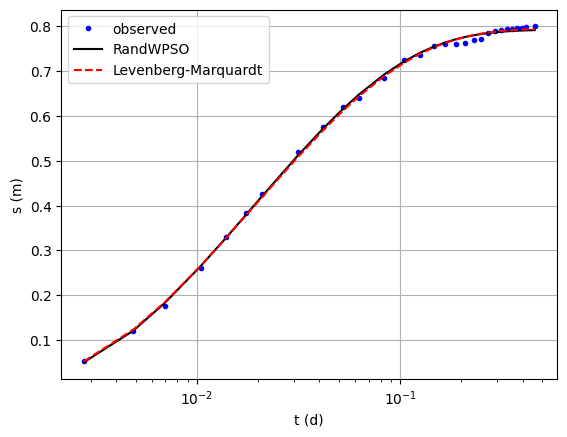

In [19]:
plt.semilogx(t_obs, s_obs, 'b.', label='observed');
plt.semilogx(t_obs, s_ai[0, 1:], 'k-', label='RandWPSO');
plt.semilogx(t_obs, s_lm[0], 'r--', label='Levenberg-Marquardt');
plt.grid();
plt.legend();
plt.xlabel('t (d)');
plt.ylabel('s (m)');

### Nelder-Mead

The Levenberg-Marquardt algorithm is a very efficient method for small unconstrained problems. As an alternative, the derivative-free [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) can be applied, which is available with SciPy function `fmin`. Instead of the residuals, this function requires the objective function as input, which is the MSE.

In [20]:
from scipy.optimize import fmin

x0 = np.array([1, -5, 2])  # starting values for logP
start = time()
x = fmin(func=MSE, x0=x0)
print(f'\t MSE = {MSE(x)}')
print(f"elapsed time: {time() - start} sec")

Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 146
         Function evaluations: 254
	 MSE = 4.948986988651328e-05
elapsed time: 0.4584951400756836 sec


In [21]:
T_nm, S_nm, c_nm = tuple(10**x)
print(f"r/B = {r_obs/np.sqrt(T_nm*c_nm)}")
print(f"T = {T_nm}")
print(f"S = {S_nm}")
print(f"c = {c_nm}")
print(f"K/M = {1/c_nm}")

r/B = 0.3396997421328106
T = 418.36094406637955
S = 0.00013910426019389012
c = 803.8793701867394
K/M = 0.0012439677358155145


Virtually the same optimal values are obtained as with the Levenberg-Marquardt optimization. However, both the Levenberg-Marquardt and Nelder-Mead algorithms can get stuck in local minima, making it crucial to choose the 'right' initial values.

In [22]:
x0 = np.array([1, -5, 0])  # starting values for logP
x = fmin(func=MSE, x0=x0)
print(f'\t MSE = {MSE(x)}')

<ipython-input-12-63eeb4f5b154>:11: RuntimeWarning: invalid value encountered in log10
  return np.log10(s_obs) - np.log10(s.flatten())


Optimization terminated successfully.
         Current function value: 0.078927
         Iterations: 159
         Function evaluations: 312
	 MSE = 0.07892673918077135


## 2. Slug test in a partially penetrating well

This section shows how to interpret a slug test performed in a well partially penetrating a confined aquifer. The Nelder-Mead method is applied to fit the slug test data and derive the optimal values for the hydraulic parameters.

### Slug test data

The slug test data are stored in file `'./data/slug_test_data.csv'`:

In [23]:
df = pd.read_csv('./data/slug_test_data.csv')
df.head()

,dt(sec),s(m)
0,0.000,-0.7138
1,0.125,-0.7131
2,0.250,-0.7083
3,0.375,-0.7048
4,0.500,-0.7055


The dataframe contains a column with the observation times and a column with the head changes. Let's further explore and visualize the data:

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5612 entries, 0 to 5611
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt(sec)  5612 non-null   float64
 1   s(m)     5612 non-null   float64
dtypes: float64(2)
memory usage: 87.8 KB


In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
dt(sec),5612.0,350.68750,202.523648,0.0000,175.34375,350.6875,526.03125,701.3750
s(m),5612.0,-0.04386,0.107725,-0.7138,-0.02160,-0.0038,-0.00140,0.0004


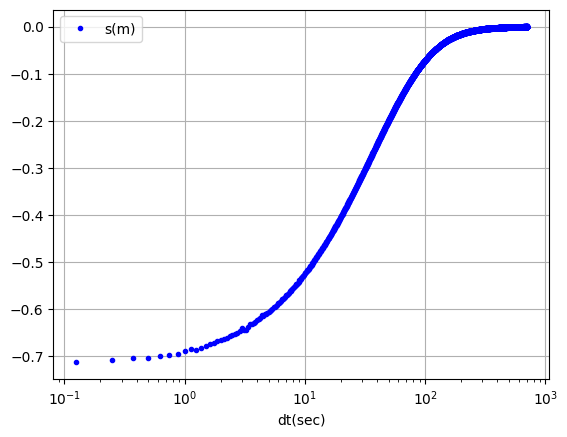

In [26]:
df.plot(x='dt(sec)', y='s(m)', style='b.', logx=True, grid=True);

In total, there are 5612 samples, and the sampling frequency is 8 samples per second, which is considered very high for this type of test. Since the observations at the beginning of the test are significantly more important, we perform a resampling of the data using a logarithmically spaced timeseries:

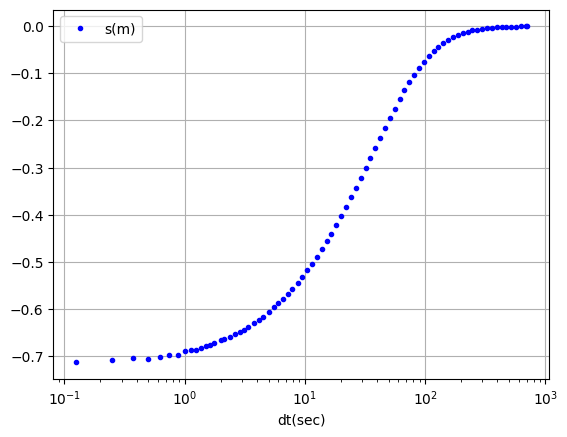

In [27]:
# Generate the target time values
target_times = np.logspace(-1, 3, 100)

# Find the closest time values in the dataframe for each target time
closest_times = []
for target_time in target_times:
    closest_times.append(df['dt(sec)'].iloc[(np.abs(df['dt(sec)'] - target_time)).argmin()])

# Convert the list of closest times to a numpy array to enable boolean indexing
closest_times = np.array(closest_times)

# Select rows from the dataframe where 'dt(sec)' is in the list of closest times
# Use .isin to efficiently check for multiple values
# and .drop_duplicates to ensure uniqueness
new_df = df[df['dt(sec)'].isin(closest_times)].drop_duplicates(subset=['dt(sec)'])

# Plot the result
new_df.plot(x='dt(sec)', y='s(m)', style='b.', logx=True, grid=True);

The result looks good as we now have a time series with data points that are more or less equally spaced on a logarithmic time scale. Let's assign the two columns in the new dataframe to variables `t_obs` and `s_obs`, and convert the times from seconds to days:

In [28]:
t_obs = new_df['dt(sec)'].values / 60 / 60 / 24  # sec -> day
s_obs = -new_df['s(m)'].values  # positive values

The first data point corresponds to the initial head change $H_0$ in the well at $t=0$ :

In [29]:
H0 = s_obs[0]
t_obs, s_obs = t_obs[1:], s_obs[1:]  # remove first data point

### KGS model

The slug test is conducted in a well partially penetrating a layer of clayey sand, which is bounded both above and below by a clay layer. The aquifer has a thickness $B$ of 11 m, and because the head change caused by the slug test is relatively small, it may be considered confined. The distance $d$ between the top of the well-screen and the aquifer top is 4 m. The screen has a length $b$ of 2 m, and the well diameter $r_w$ is 57 mm. The figure below conceptualizes the well in the aquifer:

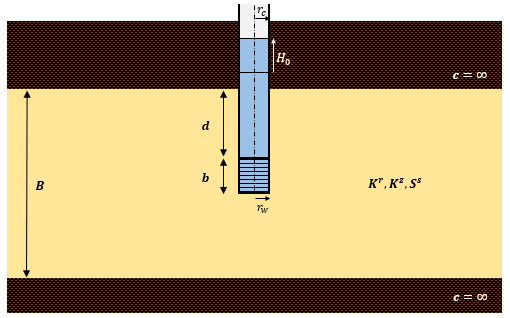

The Kansas Geological Survey developed a semi-analytical model for the simulation of a slug test in a partially penetrating well. The MAxSyPy package offers a Python implementation of the KGS model:

In [30]:
from maxsypy.kgs import KGS_no_skin

print(inspect.getdoc(KGS_no_skin))

Simulate KGS model (without well-skin)
- t (array_like) is time [T]
- H0 (float) is initial head change [L] in well
- rw (float) is well-screen radius [L]
- rc (float) is well-casing radius [L]
- B (float) is aquifer thickness [L]
- b (float) is screen length [L]
- d (float) is distance between screen top and aquifer top
- confined (bool) indicates whether the aquifer is confined (True) or phreatic (False)
- Kr (float) is the horizontal conductivity [L/T]
- Kz (float) is the vertical conductivity [L/T]
- Ss (float) is the specific storage [1/L]
- ns (int) is the Stehfest number (default is 12)
- maxerr (float) is the stop criterion, the maximum absolute head difference (default is 1e-6)
- miniter (int) is the minimum number of iterations (default is 10)
- maxiter (int) is the maximum number of iterations (default is 500)
- htol (float) is the normalized head tolerance (default is 1e-5)
returns the simulated head changes in the well for given times t, the number of iterations,
and the c

Note that we import function `KGS_no_skin` as we do not consider a well-skin. To make the interpretation more straightforward, wrapper function `simulate` is defined, which only has the hydraulic parameters as input:

In [31]:
def simulate(Kr, Kz, Ss):

    s, _, _ = KGS_no_skin(
        t = t_obs,        # simulation times (d)
        confined = True,  # confined aquifer
        b = 2,            # screen length (m)
        B = 11,           # aquifer thickness (m)
        d = 4,            # distance (m) between top of screen and water table
        rw = 0.0285,      # radius (m) of well-screen
        rc = 0.0285,      # radius (m) of well-casing
        Kr = Kr,          # horizontal conductivity (m/d) of aquifer
        Kz = Kz,          # vertical conductivity (m/d) of aquifer
        Ss = Ss,          # specific storage (1/m) of aquifer
        H0 = H0           # initial and instantaneous head change (m) in the well
    )
    return s

The test has already been interpreted by visually fitting the slug test data to drawdown curves simulated using the KGS model. These are the manually derived parameter values:

In [32]:
Kr = 2.22     # horizontal conductivity (m/d) of aquifer
Kz = 0.07     # vertical conductivity (m/d) of aquifer
Ss = 0.00009  # specific storage (1/m) of aquifer

Let's simulate and plot the result of this manual interpretation:

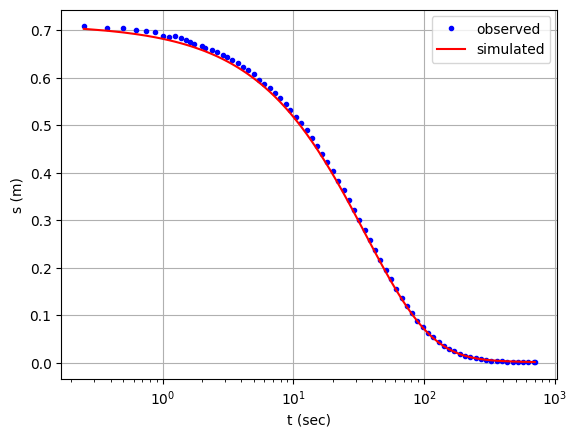

In [33]:
s = simulate(Kr, Kz, Ss)
t_sec = t_obs * 3600 * 24

plt.semilogx(t_sec, s_obs, 'b.', label='observed');
plt.semilogx(t_sec, s, 'r-', label='simulated');
plt.legend();
plt.xlabel('t (sec)');
plt.ylabel('s (m)');
plt.grid();

There is a very good agreement between the simulated curve and the observed data. However, the problem is that such a manual curve-fitting method is subjective. Therefore, let's apply the Nelder-Mead method to fit the data.

### Nelder-Mead

Like in previous example, we define functions `residuals` and `MSE`:

In [34]:
def residuals(logP):
    '''
    logP: array_like
        Logarithm of the optimized hydraulic parameters
        logP = [log10(Kr), log10(Kz), log10(Ss)]
    returns: ndarray
           Residuals of the observations
    '''
    Kr, Kz, Ss = tuple(10**logP)
    s = simulate(Kr, Kz, Ss)
    return s_obs - s  # no log transform!

MSE = lambda logP: np.mean(np.square(residuals(logP)))  # mean squared error

Note that we do not normalize the data because the values are already between 0 and 1.

Recall that the Nelder-Mead method is implemented in SciPy function `fmin`:

In [35]:
from scipy.optimize import fmin

x0 = np.array([0, 0, -5])  # starting values for logP
x = fmin(func=MSE, x0=x0)
print(f'\t MSE = {MSE(x)}')

Kr, Kz, Ss = tuple(10**x)
print('\nOptimal values:')
print(f'\t Kr = {Kr} m/d')
print(f'\t Kz = {Kz} m/d')
print(f'\t Ss = {Ss} m^-1')

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 232
         Function evaluations: 412
	 MSE = 4.58556435401376e-06

Optimal values:
	 Kr = 3.2437663500170486 m/d
	 Kz = 0.0001843799706562987 m/d
	 Ss = 1.718446610208439e-06 m^-1


We got a solution! Let's plot the result:

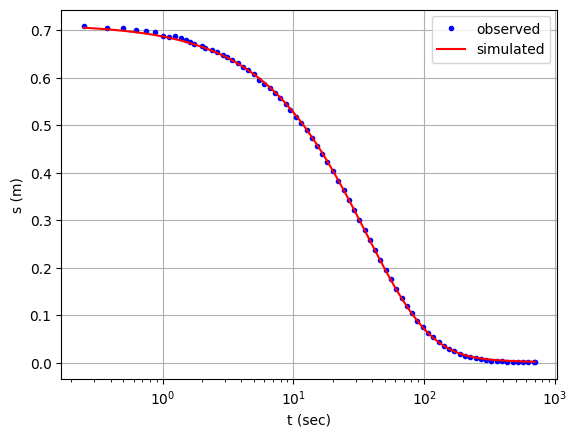

In [36]:
s = simulate(Kr, Kz, Ss)
plt.semilogx(t_sec, s_obs, 'b.', label='observed');
plt.semilogx(t_sec, s, 'r-', label='simulated');
plt.grid();
plt.legend();
plt.xlabel('t (sec)');
plt.ylabel('s (m)');

We can clearly see that the Nelder-Mead method provides a better fit! Here too, the choice of initial values is crucial to arriving at a solution. The optimal value for the horizontal conductivity is slightly higher than the manually derived value, while the optimal values for the other two parameters differ significantly. However, it should be noted that in general, vertical conductivity and specific storage cannot be reliably derived from slug test data.

---